# FMCW Radar with a Corner Reflector 

This is an example of using `RadarSimPy` to simulate an FMCW radar with a corner reflector model (not an ideal point target). Ray-Tracing/Shoot-and-Bounce-Rays method is used in `RadarSimPy`. The ray-tracing engine `RadarSimC`, which is built with C++, is integrated in RadarSimPy.

>`RadarSimPy` is a radar simulation package built with python. **<a href="https://zpeng.me/#contact" target="_blank">Contact me</a> if you are interested in this module.**

This notebook is available on my <a href="https://github.com/rookiepeng/radar-simulation-notebooks" target="_blank">GitHub</a>.

---

## Setup FMCW radar

### Transmitter

The following table lists the basic parameters of the radar transmitter.

 | Parameter                       | Variable in `RadarSimPy` | Value      |
 |---------------------------------|--------------------------|------------|
 | Center frequency ($f_c$)        | fc                       | 77 GHz     |
 | Bandwidth ($B$)                 | bandwidth                | 100 MHz    |
 | Transmitted power ($P_t$)       | tx_power                 | 10 dBm     |
 | Rising or falling chirp         | slop_type                | rising     |
 | Chirp repetition period ($CRP$) | repetition_period        | 100 us     |
 | Chirp length ($T$)              | pulse_length             | 80 us      |
 | Number of chirps                | pulses                   | 256        |
 | Chirp start delay               | delay                    | 0 s        |
 
### Receiver
 The parameters of the receiver are listed in the table below.

 | Parameter                        | Variable in `RadarSimPy` | Value        |
 |----------------------------------|--------------------------|--------------|
 | Sampling rate ($f_s$)            | fs                       | 2 Msps       |
 | Noise figure ($NF$)              | noise_figure             | 12 dB        |
 | RF gain/loss ($G_{rf}$)          | rf_gain                  | 20 dB        |
 | Load resistor ($R_L$)            | load_resistor            | 500 $\Omega$ |
 | Baseband voltage gain ($G_{BB}$) | baseband_gain            | 30 dB        |


In [110]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

angle = np.arange(-90, 91, 1)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01)

tx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)

tx = Transmitter(f=[1e9-50e6, 1e9+50e6],
                 t=[0, 80e-6],
                 tx_power=15,
                 prp=0.5,
                 pulses=180,
                 channels=[tx_channel])

rx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)

rx = Receiver(fs=2e6,
              noise_figure=8,
              rf_gain=20,
              load_resistor=500,
              baseband_gain=30,
              channels=[rx_channel])


radar = Radar(transmitter=tx, receiver=rx)

## Corner reflector model

The corner reflector model is with `.stl`. It can be imported by using `numpy-stl` module. 

In [111]:
target_1 = {
    'model': '../models/plate5x5.stl',
    'location': (200, 0, 0),
    'speed': (0, 0, 0),
    'rotation_rate': (0, 1, 0),
}

targets = [target_1]

Plot the 3D mesh of the corner reflector

In [112]:
from stl import mesh

import plotly.express as px

import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.display import SVG, display

mesh_data = mesh.Mesh.from_file('../models/plate5x5.stl')

x = np.ravel(mesh_data.vectors[:, :, 0])
y = np.ravel(mesh_data.vectors[:, :, 1])
z = np.ravel(mesh_data.vectors[:, :, 2])

cr = go.Mesh3d(x=x, y=y, z=z, opacity=1,
               i=np.arange(0, np.shape(mesh_data.vectors)[0]*3, 3),
               j=np.arange(1, np.shape(mesh_data.vectors)[0]*3, 3),
               k=np.arange(2, np.shape(mesh_data.vectors)[0]*3, 3),
               intensity=z, colorscale='Viridis'
               )



fig = go.Figure(data=[cr])
iplot(fig)
# display(SVG(fig.to_image(format='svg', scale=1)))

## Raytracing

In [134]:
from radarsimpy.rt import scene
import time

tic = time.time()
data = scene(radar, targets, density=0.4, noise=False, level='pulse')

baseband = data['baseband']
toc = time.time()

print('Exection time:', toc-tic, 's')

Exection time: 26.409936904907227 s


In [140]:
px.scatter_3d(x=data['rays']['positions'][:,0], y=data['rays']['positions'][:,1], z=data['rays']['positions'][:,2], color=data['rays']['pulse_idx'][:,0])

# fig = go.Figure(data=[cr])
# iplot(fig)

## Radar signal processing

In [117]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.cal_range_profile(radar, baseband, range_window)

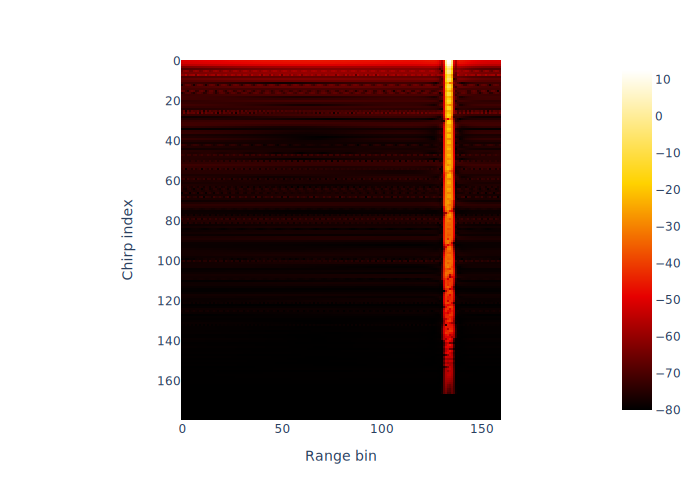

In [154]:
fig = px.imshow(temp, color_continuous_scale='hot')
fig.update_xaxes(title='Range bin')
fig.update_yaxes(title='Chirp index')
display(SVG(fig.to_image(format='svg', scale=1)))

In [130]:


# px.line(df, x="year", y="lifeExp", title='Life expectancy in Canada')

temp = np.abs(range_profile[0, :, :])
temp = 20 * np.log10(temp + 0.0001)

px.line(y=temp[:,133])